<a href="https://colab.research.google.com/github/Sharma-Pranav/Tensorflow_Training/blob/master/Custom_Training_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function

In [0]:
import os
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

In [4]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.13.1
Eager execution: True


In [0]:
train_dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv'

In [6]:
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url), origin = train_dataset_url)



8192/2194 [================================================================================================================] - 0s 0us/step


In [7]:
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


In [8]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [0]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [10]:
feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [0]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [0]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(train_dataset_fp, batch_size, column_names = column_names, label_name = label_name, num_epochs = 1)

In [0]:
features, labels = next(iter(train_dataset))

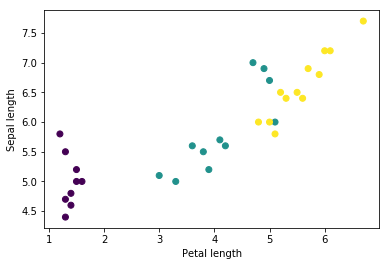

In [17]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [0]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [0]:
train_dataset = train_dataset.map(pack_features_vector)

In [20]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.3 2.9 6.3 1.8]
 [6.6 2.9 4.6 1.3]
 [6.2 2.2 4.5 1.5]
 [5.5 2.6 4.4 1.2]
 [5.4 3.7 1.5 0.2]], shape=(5, 4), dtype=float32)


In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [22]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=214, shape=(5, 3), dtype=float32, numpy=
array([[ 5.5361037, -3.276522 ,  6.60592  ],
       [ 4.794073 , -2.7837372,  5.7453384],
       [ 4.496839 , -2.6521018,  5.388019 ],
       [ 4.139655 , -2.402677 ,  4.9474177],
       [ 4.068958 , -1.5413368,  4.336762 ]], dtype=float32)>

In [23]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=220, shape=(5, 3), dtype=float32, numpy=
array([[2.5542834e-01, 3.8018461e-05, 7.4453366e-01],
       [2.7859071e-01, 1.4254941e-04, 7.2126675e-01],
       [2.9079992e-01, 2.2848025e-04, 7.0897162e-01],
       [3.0823049e-01, 4.4419823e-04, 6.9132531e-01],
       [4.3275970e-01, 1.5838970e-03, 5.6565636e-01]], dtype=float32)>

In [24]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels: [2 1 1 1 0 0 2 1 0 2 0 0 0 1 0 0 1 2 1 2 2 0 0 2 1 2 0 2 1 2 1 2]


In [0]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [26]:
l = loss(model, features, labels)
print("Loss test: {}".format(l))

Instructions for updating:
Use tf.cast instead.
Loss test: 3.0267410278320312


In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

In [29]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 3.0267410278320312
Step: 1,         Loss: 2.5990259647369385


In [0]:
from tensorflow import contrib
tfe = contrib.eager

In [0]:
# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

In [32]:
for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)
    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
    
    # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.019, Accuracy: 67.500%
Epoch 050: Loss: 0.423, Accuracy: 83.333%
Epoch 100: Loss: 0.294, Accuracy: 95.833%
Epoch 150: Loss: 0.208, Accuracy: 95.833%
Epoch 200: Loss: 0.150, Accuracy: 97.500%


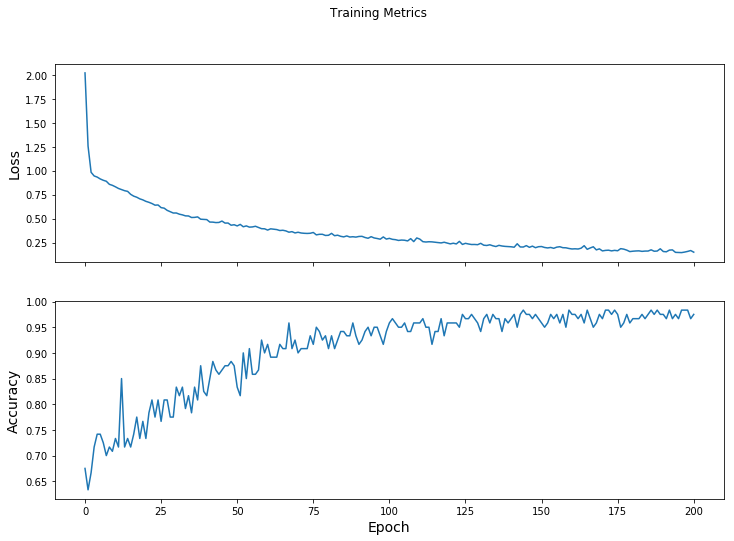

In [33]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [34]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [36]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [37]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=107898, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

In [38]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (97.3%)
Example 1 prediction: Iris versicolor (91.7%)
Example 2 prediction: Iris virginica (74.9%)
